# 模型boosting

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
# dnn模型构建
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F
import random
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
        datefmt='%m/%d/%Y %H:%M:%S',
        level=logging.INFO)

In [2]:
# 固定随机数种子，确保实验的可重复性
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

def get_fft_and_scaler(data, start=5192, end=8192):
    data = np.fft.fft(data)
    data = np.abs(data)
    data = data/np.expand_dims(data.max(axis=1), axis=1)
    return data[:, start:end]

# 搭建DNN模型
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.dnn = nn.Sequential(
            nn.BatchNorm1d(300),
            nn.Linear(300, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.dnn(x)
        return F.softmax(x, dim=1)

def get_boost_data(feature, preds_label, true_label):
    return feature[preds_label == true_label, :].detach().cpu(), true_label[preds_label == true_label].detach().cpu()

def model_train(train_loader, model, optimizer, criterion, labels, boost=True):
    model.train()
    train_total_acc = 0
    train_loss = 0
    for feature, label in train_loader:
        feature = feature.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        preds = model(feature)

        loss = criterion(preds, label)
        loss.backward()
        optimizer.step()
        # 存储boosting数据
        if epoch >= epochs - boost_epoch_num  and boost:
            d1, d2 = get_boost_data(feature, preds.argmax(dim=1), label)
            boost_feature.append(d1)
            boost_label.append(d2)

        train_total_acc += model(feature).argmax(dim=1).eq(label).sum().item()
        train_loss += loss.item()

        feature.cpu()
        label.cpu()

    print(
        f'Training loss: {train_loss/len(train_loader):.4f}',
        f'Training  acc: {train_total_acc/len(labels):.4f}',
         )

def predict(val_loader, model, criterion, labels):
    model.eval()
    val_total_acc = 0
    val_loss = 0
    for feature, label in val_loader:
        feature = feature.to(device)
        label = label.to(device)
        preds = model(feature)
        loss = criterion(preds, label)

        val_total_acc += model(feature).argmax(dim=1).eq(label).sum().item()
        val_loss += loss.item()

        feature.cpu()
        label.cpu()

    print(
        f'Val loss: {val_loss/len(val_loader):.4f}',
        f'Val  acc:{val_total_acc/len(labels):.4f}'
    )
    return val_loss

In [3]:
print('loading data')
# 读取训练集，测试集和验证集
train = np.load('../train/10type_sort_train_data_8192.npy')
val = np.load('../val/10type_sort_eval_data_8192.npy')

# 读取训练集和验证集的标签，测试集是没有标签的，需要你使用模型进行分类，并将结果进行提交
train_label = np.load('../train/10type_sort_train_label_8192.npy')
val_label = np.load('../val/10type_sort_eval_label_8192.npy')

train_sp = get_fft_and_scaler(train, start=6892, end=7192)
val_sp = get_fft_and_scaler(val, start=6892, end=7192)

# 将数据转换成pytorch的tensor
batch_size = 128

train_tensor = torch.tensor(train_sp).float()
y_train_tensor = torch.tensor(train_label).long()
val_tensor = torch.tensor(val_sp).float()
y_val_tensor = torch.tensor(val_label).long()

# 使用Dataloader对数据进行封装
val_tensor = TensorDataset(val_tensor, y_val_tensor)
val_loader = DataLoader(val_tensor, shuffle=False, batch_size=batch_size)

loading data


In [4]:
lr = 0.0001
gamma = 0.9
step_size = 1
epochs = 30
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [5]:
# 使用boost ing的想法，让神经网络学习错误的类别
# boosting 的想法：训练后面几次，分类错误的数据
# 重新定义一个新的分类器进行学习错误的数据, 保存这些模型的参数
# 然后使用模型融合
boost_epoch_num = 4
for boost_num in range(boost_epoch_num):
    # 分类器学习, 更新训练集
    train_dataset = TensorDataset(train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
    model = DNN().to(device)
    boost_feature = []
    boost_label = []
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_best = float('inf')
    best_model = None
    
    print('--'*8 + f'boost round: {boost_num}/{boost_epoch_num}' + '--'*8)
    print(train_tensor.shape, y_train_tensor.shape)
    for epoch in range(epochs):
        print('='*20 + f' Epoch: {epoch} '+ '='*20)
        model_train(train_loader=train_loader, optimizer=optimizer, criterion=criterion, labels=y_train_tensor, model=model, boost=True)
        loss = predict(val_loader, model, criterion=criterion, labels=y_val_tensor)
        if loss <= train_best:
            train_best = loss
            best_model = model
    torch.save(best_model.state_dict(), f'./best_model{str(boost_num)}.point')
    # 开始boosting
    train_tensor = torch.cat(boost_feature, dim=0)
    y_train_tensor = torch.cat(boost_label, dim=0)

----------------boost round: 0/4----------------
==================== Epoch: 0 ====================
Training loss: 2.0387 Training  acc: 0.4588
Val loss: 2.0017 Val  acc:0.4544
==================== Epoch: 1 ====================
Training loss: 1.9170 Training  acc: 0.5610
Val loss: 1.9623 Val  acc:0.5002
==================== Epoch: 2 ====================
Training loss: 1.8857 Training  acc: 0.5879
Val loss: 1.9482 Val  acc:0.5132
==================== Epoch: 3 ====================
Training loss: 1.8708 Training  acc: 0.6010
Val loss: 1.9466 Val  acc:0.5114
==================== Epoch: 4 ====================
Training loss: 1.8485 Training  acc: 0.6259
Val loss: 1.9138 Val  acc:0.5527
==================== Epoch: 5 ====================
Training loss: 1.8342 Training  acc: 0.6397
Val loss: 1.9162 Val  acc:0.5462
==================== Epoch: 6 ====================
Training loss: 1.8256 Training  acc: 0.6471
Val loss: 1.9051 Val  acc:0.5580
==================== Epoch: 7 ====================
Trai

Val loss: 1.8716 Val  acc:0.5878
==================== Epoch: 3 ====================
Training loss: 1.4893 Training  acc: 0.9772
Val loss: 1.8683 Val  acc:0.5909
==================== Epoch: 4 ====================
Training loss: 1.4839 Training  acc: 0.9815
Val loss: 1.8757 Val  acc:0.5833
==================== Epoch: 5 ====================
Training loss: 1.4806 Training  acc: 0.9842
Val loss: 1.8717 Val  acc:0.5874
==================== Epoch: 6 ====================
Training loss: 1.4778 Training  acc: 0.9864
Val loss: 1.8621 Val  acc:0.5970
==================== Epoch: 7 ====================
Training loss: 1.4761 Training  acc: 0.9877
Val loss: 1.8665 Val  acc:0.5926
==================== Epoch: 8 ====================
Training loss: 1.4747 Training  acc: 0.9887
Val loss: 1.8679 Val  acc:0.5909
==================== Epoch: 9 ====================
Training loss: 1.4737 Training  acc: 0.9897
Val loss: 1.8677 Val  acc:0.5916
==================== Epoch: 10 ====================
Training loss: 1.47

KeyboardInterrupt: 

# 模型stacking

In [63]:
model0 = DNN().to(device)
model1 = DNN().to(device)
model2 = DNN().to(device)
model3 = DNN().to(device)
model0.load_state_dict(torch.load('best_model0.point'))
model1.load_state_dict(torch.load('best_model1.point'))
model2.load_state_dict(torch.load('best_model2.point'))
model3.load_state_dict(torch.load('best_model3.point'))

<All keys matched successfully>

In [64]:
model0.eval()
model1.eval()
model2.eval()
model3.eval()
preds0 = model0(torch.FloatTensor(val_sp).to(device)).argmax(dim=1).cpu().numpy()
preds1 = model1(torch.FloatTensor(val_sp).to(device)).argmax(dim=1).cpu().numpy()
preds2 = model2(torch.FloatTensor(val_sp).to(device)).argmax(dim=1).cpu().numpy()
preds3 = model3(torch.FloatTensor(val_sp).to(device)).argmax(dim=1).cpu().numpy()

In [65]:
ans0 = model0(torch.FloatTensor(val_sp).to(device)).cpu()
ans1 = model1(torch.FloatTensor(val_sp).to(device)).cpu()
ans2 = model2(torch.FloatTensor(val_sp).to(device)).cpu()
ans3 = model3(torch.FloatTensor(val_sp).to(device)).cpu()

In [66]:
(preds3 == val_label).sum()/len(val_label)

0.3131649788488655

In [44]:
feature = np.stack([preds0, preds1, preds2], axis=1)

In [45]:
feature.shape

(23403, 3)

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
x_train, x_test, y_train, y_test = train_test_split(feature, val_label)

In [67]:
from catboost import Pool, CatBoostClassifier

In [76]:
model = CatBoostClassifier(#loss_function="Logloss",
                           eval_metric="AUC",
                           task_type="GPU",
                           learning_rate=0.1,
                           iterations=50,
                           l2_leaf_reg=50,
                           random_seed=43,
                           od_type="Iter",
                           depth=5,
                           early_stopping_rounds=1000,
                           border_count=64,
                           loss_function='MultiClass',
                           #has_time= True
                          )

In [77]:
model.fit(
    x_train, y_train,
    eval_set=(x_test, y_test),
)
preds = model.predict(x_test)
print((preds.flatten() == y_test).sum() / len(y_test))

AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8581913	best: 0.8581913 (0)	total: 68ms	remaining: 3.33s
1:	test: 0.8734694	best: 0.8734694 (1)	total: 156ms	remaining: 3.73s
2:	test: 0.8753030	best: 0.8753030 (2)	total: 237ms	remaining: 3.72s
3:	test: 0.8783921	best: 0.8783921 (3)	total: 344ms	remaining: 3.95s
4:	test: 0.8863586	best: 0.8863586 (4)	total: 429ms	remaining: 3.86s
5:	test: 0.8881551	best: 0.8881551 (5)	total: 506ms	remaining: 3.71s
6:	test: 0.8926710	best: 0.8926710 (6)	total: 592ms	remaining: 3.64s
7:	test: 0.8927174	best: 0.8927174 (7)	total: 686ms	remaining: 3.6s
8:	test: 0.8940856	best: 0.8940856 (8)	total: 774ms	remaining: 3.52s
9:	test: 0.8958414	best: 0.8958414 (9)	total: 879ms	remaining: 3.52s
10:	test: 0.8964050	best: 0.8964050 (10)	total: 960ms	remaining: 3.4s
11:	test: 0.8967690	best: 0.8967690 (11)	total: 1.03s	remaining: 3.26s
12:	test: 0.8978529	best: 0.8978529 (12)	total: 1.1s	remaining: 3.12s
13:	test: 0.8980099	best: 0.8980099 (13)	total: 1.16s	remaining: 2.99s
14:	test: 0.8989150	best: 0.89

# boosting test

In [67]:
import os
os.listdir()

['.ipynb_checkpoints',
 'best_model1.point',
 'boost_dnn.py',
 't.log',
 'eda.ipynb',
 'best_model.point']

In [16]:
model1.eval()
model2.eval()
model1 = DNN().to(device)
model2 = DNN().to(device)

In [17]:
model1.load_state_dict(torch.load('best_model0.point'))
model2.load_state_dict(torch.load('best_model1.point'))

<All keys matched successfully>

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

06/14/2021 12:50:14 - WARNING - matplotlib.style.core -   In /home/zwl/miniconda3/envs/asr/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
06/14/2021 12:50:14 - WARNING - matplotlib.style.core -   In /home/zwl/miniconda3/envs/asr/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
06/14/2021 12:50:14 - WARNING - matplotlib.style.core -   In /home/zwl/miniconda3/envs/asr/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
06/14/2021 12:50:14 - WARNING - matplotlib.style.core -   In /home/zwl/miniconda3/envs/asr

In [9]:
def plot_cm(preds, label, file_name, n_classes=10):
    '''
    label:真实标签，一维ndarray或者数组都行
    preds:模型的预测值
    n_classes:看问题是几分类问题, 默认是10分类问题
    '''
    cm = confusion_matrix(label, preds)
    def plot_Matrix(cm, classes, title=None,  cmap=plt.cm.Blues):
        plt.rc('font',family='Times New Roman',size='8')   # 设置字体样式、大小
        
        # 按行进行归一化
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # 占比1%以下的单元格，设为0，防止在最后的颜色中体现出来
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                if int(cm[i, j]*100 + 0.5) == 0:
                    cm[i, j]=0

        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        # ax.figure.colorbar(im, ax=ax) # 侧边的颜色条带
        
        ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='Actual',
            xlabel='Predicted')

        # 通过绘制格网，模拟每个单元格的边框
        ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.2)
        ax.tick_params(which="minor", bottom=False, left=False)

        # 将x轴上的lables旋转45度
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # 标注百分比信息
        fmt = 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                if int(cm[i, j]*100 + 0.5) > 0:
                    ax.text(j, i, format(int(cm[i, j]*100 + 0.5) , fmt) + '%',
                            ha="center", va="center",
                            color="white"  if cm[i, j] > thresh else "black")
        fig.tight_layout()
        plt.savefig(file_name, dpi=300)
        plt.show()

    plot_Matrix(cm, range(n_classes))

06/14/2021 12:50:14 - WARNING - matplotlib.font_manager -   findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


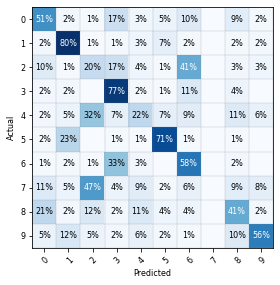

In [10]:
plot_cm(model1(torch.FloatTensor(val_sp).to(device)).argmax(dim=1).detach().cpu(), torch.LongTensor(val_label), 'model1.png')

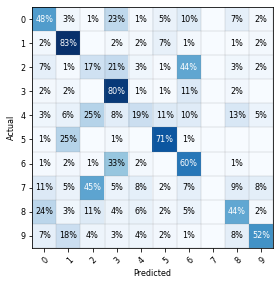

In [11]:
plot_cm(model2(torch.FloatTensor(val_sp).to(device)).argmax(dim=1).detach().cpu(), torch.LongTensor(val_label), 'model2.png')

In [18]:
preds1 = model1(torch.FloatTensor(val_sp).to(device))
preds2 = model2(torch.FloatTensor(val_sp).to(device))

In [13]:
preds1.shape

torch.Size([23403, 10])

In [113]:
preds = preds1 * 0.9 + preds2 * 0.1

In [114]:
ans = preds.argmax(dim=1)

In [115]:
(ans.cpu().numpy() == val_label).sum()/len(val_label)

0.5734307567405889

In [20]:
(preds1.argmax(dim=1).cpu().numpy() == val_label).sum()/len(val_label)

0.5719779515446738

In [119]:
boost_epoch_num = 4
for boost_num in range(boost_epoch_num):
    # 分类器学习, 更新训练集
    train_dataset = TensorDataset(train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
    model = DNN().to(device)
    boost_feature = []
    boost_label = []
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_best = float('inf')
    best_model = None
    print(f'boost round: {boost_num}/{boost_epoch_num}')
    for epoch in range(epochs):
        print('='*20 + f' Epoch: {epoch} '+ '='*20)
        train(train_loader, model, optimizer, criterion=criterion, labels=train_label)
        loss = predict(val_loader, model, criterion=criterion, labels=val_label)
        if loss <= train_best:
            train_best = loss
            best_model = model
    torch.save(best_model.state_dict(), f'./best_model{str(boost_epoch_num)}.point')
    # 开始boosting
    train_tensor = torch.cat(boost_label, dim=0)
    y_train_tensor = torch.cat(boost_feature, dim=0)


AttributeError: 'TensorDataset' object has no attribute 'size'